In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


## About this notebook
Dataset: [Manga109](http://www.manga109.org/en/)
- Process annotation
- Preprocess image
- Train VGG16 Classifier

## Helper Function

In [2]:
def get_bounding_rects(elements):
    boxes = []
    for element in elements:
        (xmin,ymin,xmax,ymax) = element.get('xmin'), element.get('ymin'), element.get('xmax'), element.get('ymax')
        boxes.append((int(xmin),int(ymin),int(xmax),int(ymax)))
    return boxes

def visualize_boxes(img, text_boxes=[], body_boxes=[], face_boxes=[], frame_boxes=[]):
    # Test Visual
    for box in text_boxes:
        x1,y1,x2,y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

    for box in body_boxes:
        x1,y1,x2,y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

    for box in face_boxes:
        x1,y1,x2,y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

    for box in frame_boxes:
        x1,y1,x2,y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

    plt.imshow(img)
    plt.show()
    
def normalize(img):
    return (img.astype(float) - 128) / 128

def preprocess(img):
    return normalize(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (224,224)))

def plotgraph(epochs, acc, val_acc, title='Model Accuracy', y_label='Accuracy'):
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

## Preprocess Data
create training dataset
- Load book list
- Loop through each book
- Load annotation
- process xml with `BeautifulSoup`
- Loop through pages
- Get `labels` from element on each page

Labels: 
- text 0
- body 1
- face 2
- frame 3

In [3]:
path = 'Dataset/Manga109'

with open('{}/{}'.format(path, 'books.txt')) as file:
    book_list = file.readlines()
book_list = [bookname.strip() for bookname in book_list]

In [4]:
len(book_list)

109

In [6]:
X = []
y = []

# For each book
for count, bookname in enumerate(tqdm(book_list)):
    # Process annotiation
    annotation_path = '{}/annotations/{}.xml'.format(path, bookname)
    with open(annotation_path, encoding='utf8') as a_file:
        content = ''.join(a_file.readlines())
        
    soup = BeautifulSoup(content, 'xml')
    
    # For each page in book
    for page in soup.find_all('page'):
        # Get classes from page
        texts = page.findChildren('text')
        bodies = page.findChildren('body')
        faces = page.findChildren('face')
        
        # Check if classes exist in page, if not then continue to next page
        if not texts and not bodies and not faces:
            continue
            
        # Get bounding boxes for each classes
        text_boxes = get_bounding_rects(texts)
        body_boxes = get_bounding_rects(bodies)
        face_boxes = get_bounding_rects(faces)
        
        # Load & Process page image.
        filename = '{}.jpg'.format(page.get('index').zfill(3))
        filepath = '{}/images/{}/{}'.format(path, bookname, filename)
        img = cv2.imread(filepath)
        
        # Crop texts 
        for box in text_boxes:
            x1,y1,x2,y2 = box
            cropped_img = img[y1:y2, x1:x2]
            X.append(preprocess(cropped_img))
            y.append(0)
            
        # Crop bodies
        for box in body_boxes:
            x1,y1,x2,y2 = box
            cropped_img = img[y1:y2, x1:x2]
            X.append(preprocess(cropped_img))
            y.append(1)
            
        # Crop faces
        for box in face_boxes:
            x1,y1,x2,y2 = box
            cropped_img = img[y1:y2, x1:x2]
            X.append(preprocess(cropped_img))
            y.append(2)

        # process 7 pages per book
        if int(page.get('index')) >= 7:
            break

    # process only 10 books
    if count >= 10:
        break

len(X), len(y)

  9%|███████▍                                                                         | 10/109 [00:05<00:52,  1.88it/s]


(2802, 2802)

In [7]:
X = np.asarray(X)
y = np.asarray(y)

## Class Distribution

<BarContainer object of 3 artists>

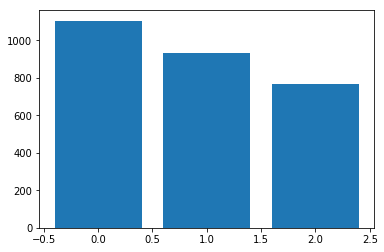

In [8]:
unique_val, counts = np.unique(y, return_counts=True)
plt.bar(unique_val, counts)

In [9]:
y = tf.keras.utils.to_categorical(y)

In [10]:
X.shape, y.shape

((2802, 224, 224, 3), (2802, 3))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.22,
                                                    random_state=42)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2185, 224, 224, 3), (617, 224, 224, 3), (2185, 3), (617, 3))

## Train Model

In [13]:
model = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=X.shape[1:],
    pooling=None,
    classes=y.shape[1],
)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='manga109.h5', 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='auto')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             min_delta=0, 
                                             patience=5, 
                                             verbose=1, 
                                             mode='auto',
                                             baseline=None, 
                                             restore_best_weights=False)

callbacks = [checkpoint, earlystop, TQDMNotebookCallback()]

In [16]:
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=8,
                    epochs=30,
                    validation_split=0.2,
                    verbose=2,
                    callbacks=callbacks)

Train on 1748 samples, validate on 437 samples


Epoch 1/30

Epoch 00001: val_loss improved from inf to 1.08733, saving model to manga109.h5
1748/1748 - 65s - loss: 1.0907 - accuracy: 0.3890 - val_loss: 1.0873 - val_accuracy: 0.3799


Epoch 2/30

Epoch 00002: val_loss improved from 1.08733 to 0.98995, saving model to manga109.h5
1748/1748 - 59s - loss: 1.0707 - accuracy: 0.4245 - val_loss: 0.9900 - val_accuracy: 0.5584


Epoch 3/30

Epoch 00003: val_loss improved from 0.98995 to 0.90814, saving model to manga109.h5
1748/1748 - 61s - loss: 0.9965 - accuracy: 0.5017 - val_loss: 0.9081 - val_accuracy: 0.5812


Epoch 4/30

Epoch 00004: val_loss improved from 0.90814 to 0.71153, saving model to manga109.h5
1748/1748 - 60s - loss: 0.8301 - accuracy: 0.6424 - val_loss: 0.7115 - val_accuracy: 0.6979


Epoch 5/30

Epoch 00005: val_loss improved from 0.71153 to 0.67418, saving model to manga109.h5
1748/1748 - 62s - loss: 0.7302 - accuracy: 0.7037 - val_loss: 0.6742 - val_accuracy: 0.7140


Epoch 6/30

Epoch 00006: val_loss improved from 0.67418 to 0.54409, saving model to manga109.h5
1748/1748 - 59s - loss: 0.6292 - accuracy: 0.7466 - val_loss: 0.5441 - val_accuracy: 0.7895


Epoch 7/30

Epoch 00007: val_loss improved from 0.54409 to 0.53830, saving model to manga109.h5
1748/1748 - 58s - loss: 0.5252 - accuracy: 0.7883 - val_loss: 0.5383 - val_accuracy: 0.7872


Epoch 8/30

Epoch 00008: val_loss did not improve from 0.53830
1748/1748 - 55s - loss: 0.4724 - accuracy: 0.8152 - val_loss: 0.6569 - val_accuracy: 0.7712


Epoch 9/30

Epoch 00009: val_loss improved from 0.53830 to 0.42631, saving model to manga109.h5
1748/1748 - 63s - loss: 0.3769 - accuracy: 0.8530 - val_loss: 0.4263 - val_accuracy: 0.8467


Epoch 10/30

Epoch 00010: val_loss improved from 0.42631 to 0.39534, saving model to manga109.h5
1748/1748 - 59s - loss: 0.3199 - accuracy: 0.8867 - val_loss: 0.3953 - val_accuracy: 0.8535


Epoch 11/30

Epoch 00011: val_loss did not improve from 0.39534
1748/1748 - 55s - loss: 0.2779 - accuracy: 0.9010 - val_loss: 0.4356 - val_accuracy: 0.8352


Epoch 12/30

Epoch 00012: val_loss did not improve from 0.39534
1748/1748 - 53s - loss: 0.1922 - accuracy: 0.9342 - val_loss: 0.4191 - val_accuracy: 0.8375


Epoch 13/30

Epoch 00013: val_loss did not improve from 0.39534
1748/1748 - 53s - loss: 0.1933 - accuracy: 0.9302 - val_loss: 0.4894 - val_accuracy: 0.8330


Epoch 14/30

Epoch 00014: val_loss did not improve from 0.39534
1748/1748 - 54s - loss: 0.1529 - accuracy: 0.9462 - val_loss: 0.4038 - val_accuracy: 0.8604


Epoch 15/30

Epoch 00015: val_loss did not improve from 0.39534
1748/1748 - 54s - loss: 0.3218 - accuracy: 0.8862 - val_loss: 0.5777 - val_accuracy: 0.8307
Epoch 00015: early stopping



In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
len(loss), len(val_loss), len(acc), len(val_acc)

(15, 15, 15, 15)

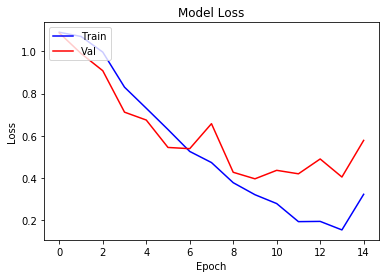

In [18]:
plotgraph(range(len(loss)), loss, val_loss, title='Model Loss', y_label='Loss')

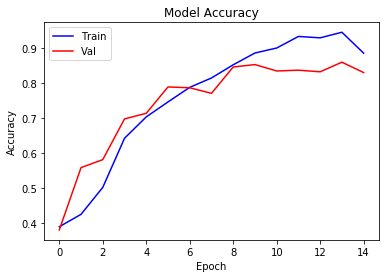

In [19]:
plotgraph(range(len(acc)), acc, val_acc)